# 階層 Bayes Model
確率分布を想定する確率 Model から、観測値との対応づけが可能な確率 Model の間に、**もう一段階、別の確率 Model が介在する**。

## 問題設定
Iris-dataset を対象に
- 分析対象の Versicolor に関しては３つしか Data がない。
- Versicolor に似た傾向の Data であることがわかっている setosa と virginica についても、それぞれ３つずつ観測値がある。

とう条件の Dataset で 階層 Bayes model を活用して Bayes推論を行なっていく。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import pymc as pm
import arviz as az
import random

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Iris-dataset の読み込み
df = sns.load_dataset('iris')

df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# Species の分布確認
df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

- sepal_length
- sepal_width

この２つの項目間の回帰式を求める。

In [4]:
# setosa の行のみ抽出
df_setosa = df[df['species'] == 'setosa']

# versicolor の行のみ抽出
df_versicolor = df[df['species'] == 'versicolor']

# virginica の行のみ抽出
df_virginica = df[df['species'] == 'virginica']

# 乱数により３個の Index を生成
random.seed(42)
indexes_versicolor = range(len(df_versicolor))
sample_indexes = random.sample(indexes_versicolor, 3)

# df_setosa, df_versicolor, df_versinica の Data数を其々、３行にする
df_setosa_sel = df_setosa.iloc[sample_indexes]
df_versicolor_sel = df_versicolor.iloc[sample_indexes]
df_virginica_sel = df_virginica.iloc[sample_indexes]

# 全部連結して１つにする
df_sel = pd.concat([df_setosa_sel, df_versicolor_sel, df_virginica_sel]).reset_index(drop=True)

In [5]:
df_sel

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,3.5,1.3,0.3,setosa
1,5.0,3.4,1.5,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,5.5,2.6,4.4,1.2,versicolor
4,4.9,2.4,3.3,1.0,versicolor
5,6.4,3.2,4.5,1.5,versicolor
6,6.7,3.1,5.6,2.4,virginica
7,7.3,2.9,6.3,1.8,virginica
8,5.8,2.7,5.1,1.9,virginica


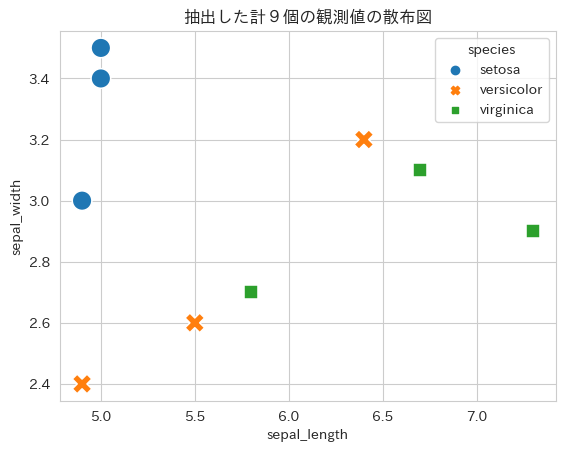

In [6]:
# 散布図による抽出結果表示
sns.scatterplot(
    x='sepal_length',
    y='sepal_width',
    hue='species',  # 色を分ける
    style='species',  # Marker を分ける
    data=df_sel,
    s=200,
)
plt.title('抽出した計９個の観測値の散布図')
plt.show()

この Data から
- x
- y
- cl

の３つの変数を抽出し、Bayes推論で利用する。

In [7]:
# Bayes推論用変数の抽出
x_sepal_length = df_sel['sepal_length'].values
y_sepal_width = df_sel['sepal_width'].values
species = df_sel['species']
classes = pd.Categorical(species).codes

print(x_sepal_length)
print(y_sepal_width)
print(species.values)
print(classes)

[5.  5.  4.9 5.5 4.9 6.4 6.7 7.3 5.8]
[3.5 3.4 3.  2.6 2.4 3.2 3.1 2.9 2.7]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


#### 変数 `classes`
- 階層 Bayes Model と直接関係している変数
- 階層 Bayes Model では、回帰式の Parameters である $\alpha$ と $beta$ は、Group(今回でいうと花の種類)により異なることが前提になる。
- 上記より、`x_sepal_length` と `y_sepal_width` もそれぞれの値が **どの Group に属するのかを示す Index** が必要になる。
- この Index を示す配列が `classes`

## 確率 Model 定義

In [8]:
# 階層 Bayes の確率 Model 定義
model = pm.Model()

with model:
    # x_sepal_length, y_sepal_width の観測値を ConstantData として定義
    x_data_sepal_length = pm.ConstantData('x_data_sepal_length', x_sepal_length)
    y_data_sepal_width = pm.ConstantData('y_data_sepal_width', y_sepal_width)

    # Class 変数定義）
    classes_data = pm.ConstantData('classes_data', classes)

    # 確率変数 alpha の定義
    a_mu = pm.Normal('a_mu', mu=0.0, sigma=10.0)
    a_sigma = pm.HalfNormal('a_sigma', sigma=10.0)
    alpha = pm.Normal('alpha', mu=a_mu, sigma=a_sigma, shape=(3,))
    # a_mu, a_sigma という別の確率変数を経由して間接的に決定。
    # shape=(3,)を追加することで、確率変数が３要素の配列（個別に予測したい花の種類）に

    # 確率変数 beta の定義
    b_mu = pm.Normal('b_mu', mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal('b_sigma', sigma=10.0)
    beta = pm.Normal('beta', mu=b_mu, sigma=b_sigma, shape=(3,))
    # b_mu, b_sigma という別の確率変数を経由して間接的に決定。
    # shape=(3,)を追加することで、確率変数が３要素の配列（個別に予測したい花の種類）に

    # 誤差 epsilon
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # mu の値は、classes_data により Index を切替えて計算
    mu = pm.Deterministic('mu', x_data_sepal_length * alpha[classes_data] + beta[classes_data])
    # x_data_sepal_length は要素数９の配列
    # alpha と beta は要素数３つの配列だが、classes_data が要素数９の配列のため、alpha[classes_data] と beta[classes_data]も要素数９の配列になる。
    # 要素数９の配列である mu には、何番目の要素であるかによって、alpha, beta の値を使いわけた形で線形予測結果が設定されることになる。

    # mu, epsilon を使って観測値用の確率 Model を定義
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=y_data_sepal_width)

In [9]:
# PyMC変数を Numpy変数に置き換えた mu の計算の仕組み

# alpha_np は要素数３の配列
alpha_np = np.array([0.1, 0.2, 0.3])
print(alpha_np)

# classes_np は要素数９の配列
classes_np = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
print(classes_np)

# mu_np も要素数９の配列になる
mu_np = alpha_np[classes_np]
print(mu_np)

[0.1 0.2 0.3]
[0 0 0 1 1 1 2 2 2]
[0.1 0.1 0.1 0.2 0.2 0.2 0.3 0.3 0.3]


PyMC の変数間でも同じ動きをしている

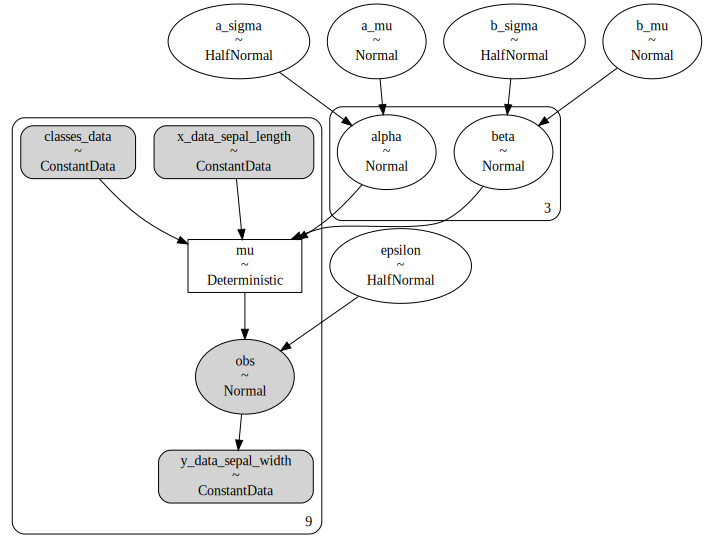

In [10]:
# 確率 Model構造の可視化
pm.model_to_graphviz(model)

### なぜ階層 Bayes Model の仕組みが使用されるか
主には Data件数との兼ね合い。今回のようにそれぞれの花で３件しか観測値がない場合、いくら Bayes推論でも十分な推論を行なうには Data が少なすぎる。
そこで、**似た傾向にある他の花の Data も参考にすることでより精度の高い推論をする**方法が Bayes推論
>50件程度の観測値がある場合は、花の種別に確率Model を構築し、Bayes推論を行なえばよい。

In [11]:
# Sampling
with model:
    idata = pm.sample(random_seed=42, target_accept=0.998, chains=2)
    # 難易度の高い確率 Model の為、target_accept を大きな値で設定

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a_mu, a_sigma, alpha, b_mu, b_sigma, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 258 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


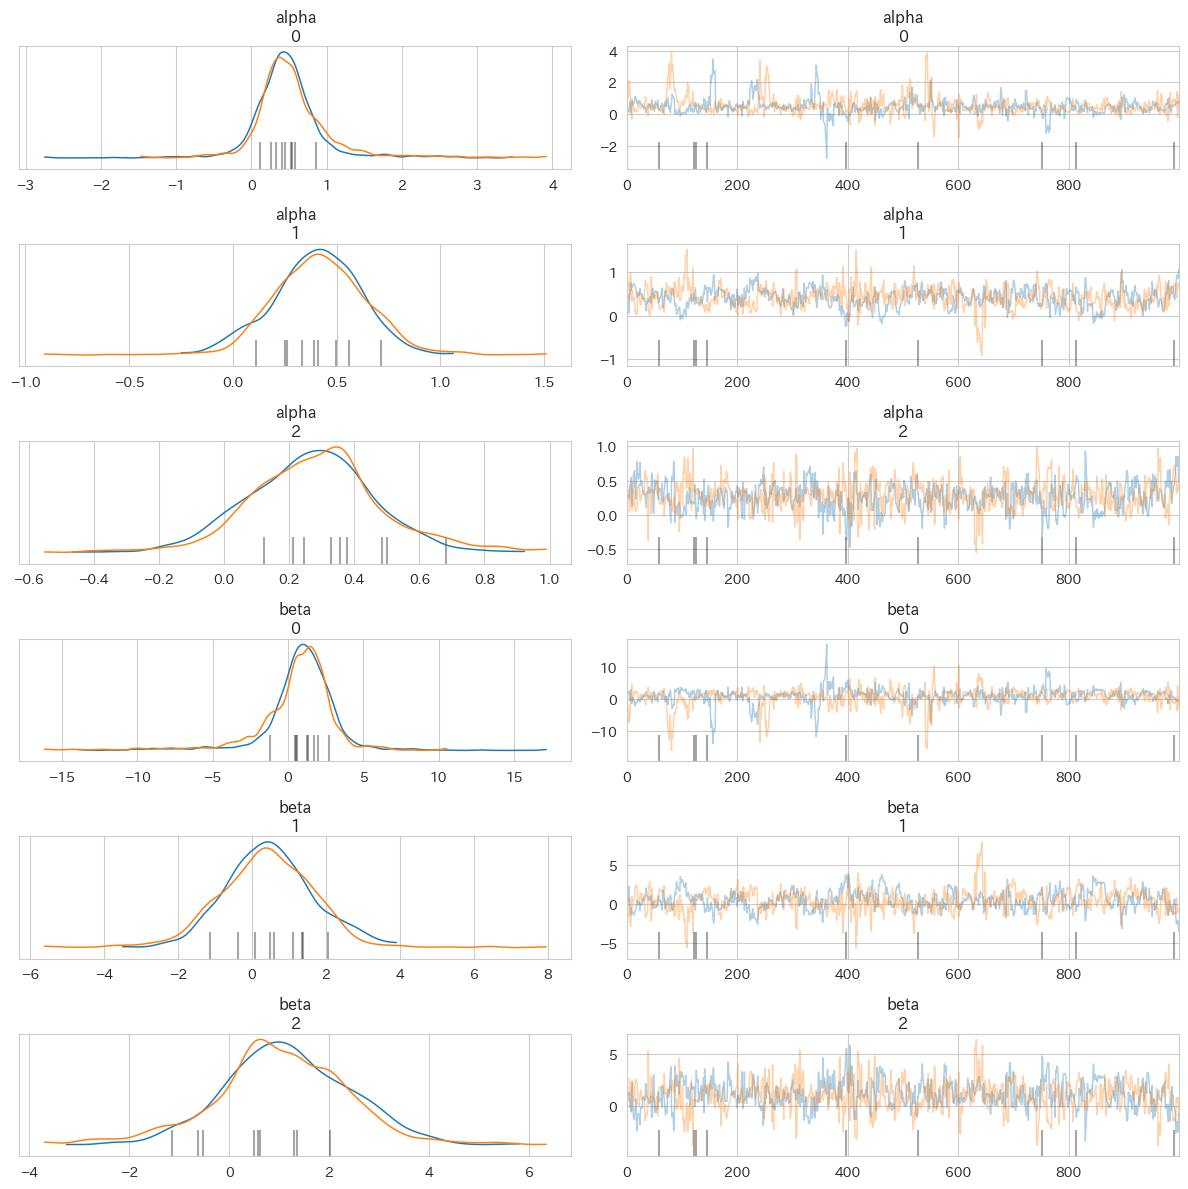

In [12]:
az.plot_trace(idata, compact=False, var_names=['alpha', 'beta',])
plt.tight_layout()
plt.show()

どちらの値も、２つの Sample値系列で同じ波形をしているので、推論結果としては問題はなさそう。

In [13]:
# Sampling結果の分析
summary = az.summary(idata, var_names=['alpha', 'beta'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.517,0.521,-0.352,1.513,0.033,0.024,267.0,272.0,1.01
alpha[1],0.410,0.230,-0.002,0.807,0.017,0.012,181.0,235.0,1.00
alpha[2],0.275,0.202,-0.120,0.647,0.011,0.008,330.0,512.0,1.00
beta[0],0.723,2.586,-4.081,5.238,0.166,0.118,267.0,270.0,1.01
beta[1],0.447,1.299,-1.642,2.958,0.097,0.069,178.0,212.0,1.00
beta[2],1.087,1.334,-1.587,3.451,0.072,0.051,340.0,575.0,1.00


- `r_hat` の値がどの行も 1.00 or 1.01 の為、正常に Bayes推論できている。
- 1次関数近似における切片（定数項）を意味する `beta` の値に関しては、振れ幅が大きく、まだ十分な推論ができていない。

## 散布図と回帰直線の重ね書き
各確率変数の平均値により代表的な回帰直線のみ Graph描画する。

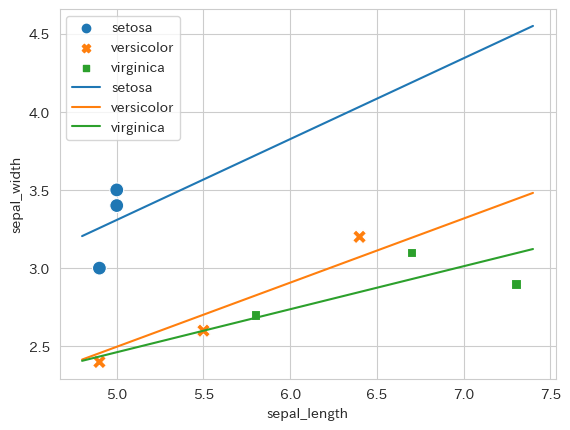

In [17]:
# alpha と beta の平均値の導出
# summary変数から `mean`, `alpha[0]` と Index をたどることで対象の確率変数の平均値を取得
means = summary['mean']
alpha_setosa = means['alpha[0]']
alpha_versicolor = means['alpha[1]']
alpha_virginica = means['alpha[2]']
beta_setosa = means['beta[0]']
beta_versicolor = means['beta[1]']
beta_virginica = means['beta[2]']

# 回帰直線用座標の計算
x_range = np.array([x_sepal_length.min() - 0.1, x_sepal_length.max() + 0.1])
y_setosa_range = alpha_setosa * x_range + beta_setosa
y_versicolor_range = alpha_versicolor * x_range + beta_versicolor
y_virginica_range = alpha_virginica * x_range + beta_virginica

# 散布図表示
sns.scatterplot(
    x='sepal_length',
    y='sepal_width',
    hue='species',  # 色を分ける
    data=df_sel,
    style='species',  # Marker を分ける
    s=100  # Marker の Size
)
plt.plot(x_range, y_setosa_range, label='setosa')
plt.plot(x_range, y_versicolor_range, label='versicolor')
plt.plot(x_range, y_virginica_range, label='virginica')
plt.legend()
plt.show()

setoosa の Random に抽出された３つの点は、近似直線の傾きでいうと、もっとも大きな傾きになっているはず。
それが、他の２つの回帰直線とほぼ同様の傾きになっているのは、階層Bayes Model を使用しているため。

実際の傾きはどちらが正しかったかは、Sample抽出前の全体の分布を見ないと何ともいえないため、Iris-dataset全体の散布図と、Bayes推論で求めた回帰直線を重ね書きし確認してみる。

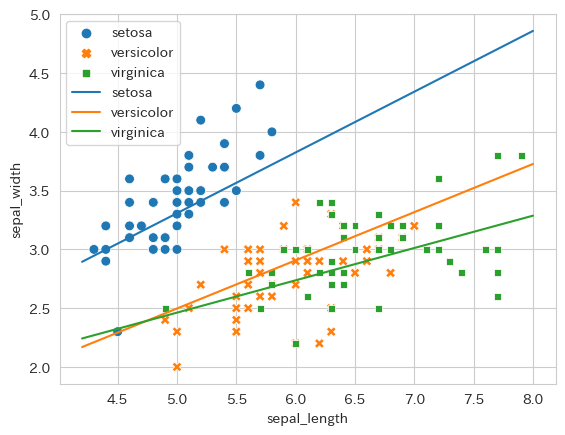

In [18]:
# 回帰直線の座標値計算
x_range = np.array([df['sepal_length'].min() - 0.1, df['sepal_length'].max() + 0.1])
y_setosa_range = alpha_setosa * x_range + beta_setosa
y_versicolor_range = alpha_versicolor * x_range + beta_versicolor
y_virginica_range = alpha_virginica * x_range + beta_virginica

# 散布図表示
sns.scatterplot(
    x='sepal_length',
    y='sepal_width',
    data=df,
    hue='species',
    style='species',
    s=50
)
plt.plot(x_range, y_setosa_range, label='setosa')
plt.plot(x_range, y_versicolor_range, label='versicolor')
plt.plot(x_range, y_virginica_range, label='virginica')
plt.legend()
plt.show()

Iris-dataset全体の散布図と比較の結果、階層Bayes-model による線形回帰の傾きの近似値は適切。

今回のような Use-case では、階層Bayes-model は有力な推論手法といえる。